<a href="https://colab.research.google.com/github/AbhiJeet70/GraphPoisoningCodes/blob/main/Meta_Planetoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing dataset: Cora


Processing...
Done!


Statistics for Cora:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Class distribution: [351 217 418 818 426 298 180]
Early stopping at epoch 147
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.8819188191881919
Early stopping at epoch 159
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.8892988929889298
Early stopping at epoch 191
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 0.0001, Accuracy: 0.8892988929889298
Early stopping at epoch 249
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 1e-05, Accuracy: 0.8874538745387454
Early stopping at epoch 103
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 0.0001, Accuracy: 0.2730627306273063
Early stopping at epoch 112
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 1e-05, Accuracy: 0.27121771217712176
Early stopping at epoch 133
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.8

/tmp/ipykernel_33/4188549061.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Perturbation Percentage: 0.05, Accuracy: 0.8763837638376384
Perturbation Percentage: 0.1, Accuracy: 0.8726937269372693
Perturbation Percentage: 0.15, Accuracy: 0.8634686346863468
Perturbation Percentage: 0.2, Accuracy: 0.8210332103321033
Perturbation Percentage: 0.25, Accuracy: 0.7822878228782287
Processing dataset: Pubmed


Processing...
Done!


Statistics for Pubmed:
  Number of nodes: 19717
  Number of edges: 88648
  Number of features: 500
  Number of classes: 3
  Class distribution: [4103 7739 7875]
Early stopping at epoch 288
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.8803245436105477
Early stopping at epoch 261
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.8770283975659229
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 0.0001, Accuracy: 0.8795638945233266
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 1e-05, Accuracy: 0.880578093306288
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 0.0001, Accuracy: 0.8263184584178499
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 1e-05, Accuracy: 0.8286004056795132
Early stopping at epoch 478
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.8780425963488844
Early stopping at epoch 256
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.8790567

Processing...
Done!


Statistics for CiteSeer:
  Number of nodes: 3327
  Number of edges: 9104
  Number of features: 3703
  Number of classes: 6
  Class distribution: [264 590 668 701 596 508]
Early stopping at epoch 128
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.7597597597597597
Early stopping at epoch 118
Hidden Channels: 16, Learning Rate: 0.1, Weight Decay: 1e-05, Accuracy: 0.7732732732732732
Early stopping at epoch 209
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 0.0001, Accuracy: 0.7852852852852853
Early stopping at epoch 263
Hidden Channels: 16, Learning Rate: 0.01, Weight Decay: 1e-05, Accuracy: 0.7687687687687688
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 0.0001, Accuracy: 0.7822822822822822
Hidden Channels: 16, Learning Rate: 0.001, Weight Decay: 1e-05, Accuracy: 0.7807807807807807
Early stopping at epoch 116
Hidden Channels: 32, Learning Rate: 0.1, Weight Decay: 0.0001, Accuracy: 0.7612612612612613
Early stopping at epoch 116
Hidden Channel

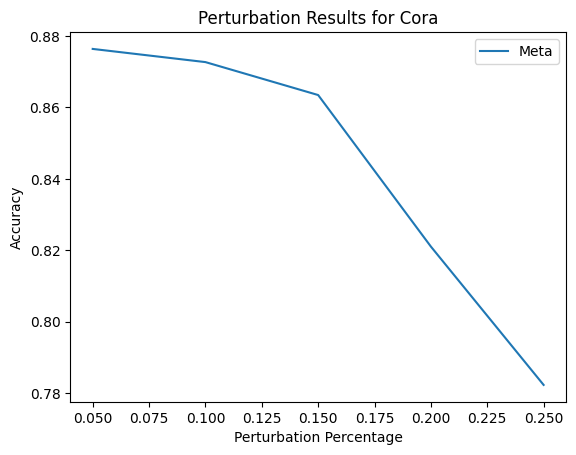

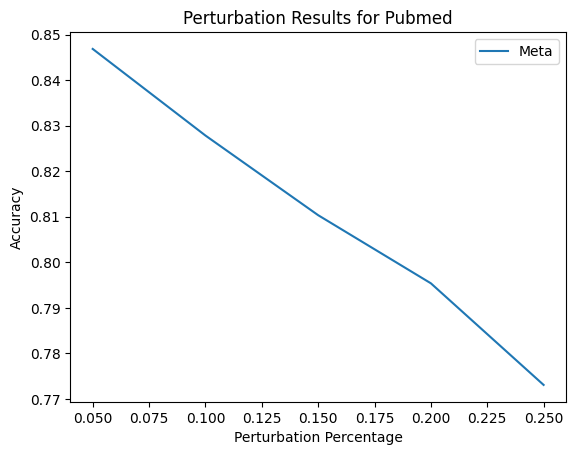

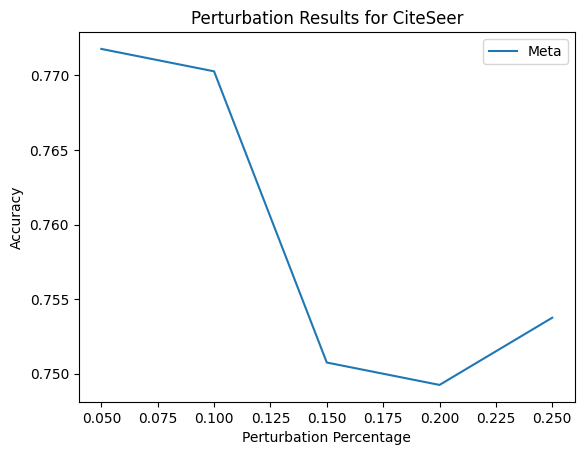

In [ ]:
# Install necessary packages
!pip install torch torch-geometric pandas matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(20)

# Define the GCN model
class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class MetaLearner(nn.Module):
    def __init__(self, model, features, adj, labels, idx_train, lambda_=0.5):
        super(MetaLearner, self).__init__()
        self.model = model
        self.features = features
        self.adj = adj
        self.labels = labels
        self.idx_train = idx_train
        self.lambda_ = lambda_
        self.adj_changes = nn.Parameter(torch.zeros_like(adj.to_dense().float()))  # Convert to float

    def forward(self, adj):
        adj = adj + self.adj_changes
        adj = torch.clamp(adj, 0, 1)
        return adj

    def loss(self, adj, output):
        return F.cross_entropy(output[self.idx_train], self.labels[self.idx_train])

def meta_attack(features, edge_index, labels, idx_train, idx_unlabeled, perturbations, lambda_=0.5, epochs=100):
    num_nodes = features.size(0)

    # Convert edge_index to dense adjacency matrix
    adj = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.size(1)), (num_nodes, num_nodes)).to_dense()

    # Initialize surrogate model
    in_channels = features.size(1)
    hidden_channels = 64
    out_channels = labels.max().item() + 1
    surrogate = GCNNet(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels)

    # Initialize meta-learner
    meta_learner = MetaLearner(model=surrogate, features=features, adj=adj, labels=labels, idx_train=idx_train, lambda_=lambda_)
    optimizer = torch.optim.Adam(meta_learner.parameters(), lr=0.01)

    # Perturb adjacency matrix
    for _ in range(perturbations):
        i = torch.randint(0, num_nodes, (1,))
        j = torch.randint(0, num_nodes, (1,))
        adj[i, j] = 1 - adj[i, j]
        adj[j, i] = adj[i, j]  # Ensure symmetry

    # Forward pass with surrogate model
    surrogate.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        perturbed_adj = meta_learner(adj)  # Apply meta-learner to get perturbed adjacency
        output = surrogate(features, edge_index)
        loss = meta_learner.loss(perturbed_adj, output)
        loss.backward()
        optimizer.step()

    # Return the perturbed adjacency matrix as edge_index
    edge_index_perturbed = perturbed_adj.nonzero(as_tuple=False).t().contiguous()
    return edge_index_perturbed

# Load data
def load_planetoid_data(dataset_name):
    dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, transform=NormalizeFeatures())
    return dataset[0]

# Split data indices
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    return torch.tensor(indices[:train_end]), torch.tensor(indices[train_end:val_end]), torch.tensor(indices[val_end:])

# Train the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    return correct / pyg_data.test_mask.sum().item()

# Define dataset statistics
def print_dataset_statistics(data, dataset_name):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {dataset_name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

def run_meta_attack_experiments(data, perturbation_percentage, model, best_hyperparams):
    train_idx = data.train_mask
    val_idx = data.val_mask

    perturbations = int(perturbation_percentage * data.edge_index.size(1))
    perturbed_data = data.clone()
    perturbed_edge_index = meta_attack(data.x, data.edge_index, data.y, train_idx, val_idx, perturbations)
    perturbed_data.edge_index = perturbed_edge_index

    # Ensure edge_index has valid indices
    valid_indices = (perturbed_data.edge_index[0] < perturbed_data.num_nodes) & (perturbed_data.edge_index[1] < perturbed_data.num_nodes)
    perturbed_data.edge_index = perturbed_data.edge_index[:, valid_indices]

    # Evaluate model on perturbed data
    model.eval()
    with torch.no_grad():
        logits = model(perturbed_data.x, perturbed_data.edge_index)
        pred = logits.argmax(dim=1)
        correct = (pred[perturbed_data.test_mask] == perturbed_data.y[perturbed_data.test_mask]).sum().item()
        acc = correct / perturbed_data.test_mask.sum().item()

    return acc

# Hyperparameter grid search
hidden_channels_list = [16, 32, 64, 128, 256, 512]  # Reduced for quicker testing
learning_rates = [0.1, 0.01, 0.001]  # Reduced for quicker testing
weight_decays = [1e-4, 1e-5]

# List of datasets to process
datasets = ['Cora', 'Pubmed', 'CiteSeer']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Dataset', 'Hidden_Channels', 'Learning_Rate', 'Weight_Decay', 'Accuracy', 'Perturbation_Type', 'Perturbation_Percentage'])

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Update the code that initializes the model
for dataset_name in datasets:
    print(f'Processing dataset: {dataset_name}')
    data = load_planetoid_data(dataset_name)
    print_dataset_statistics(data, dataset_name)

    train_idx, val_idx, test_idx = split_indices(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

    num_classes = data.y.max().item() + 1  # Calculate the number of classes

    best_accuracy = 0
    best_hyperparams = {'Hidden_Channels': None, 'Learning_Rate': None, 'Weight_Decay': None}

    for hidden_channels in hidden_channels_list:
        for lr in learning_rates:
            for wd in weight_decays:
                model = GCNNet(data.num_node_features, hidden_channels, num_classes)
                accuracy = train_model(model, data, lr, wd)
                print(f'Hidden Channels: {hidden_channels}, Learning Rate: {lr}, Weight Decay: {wd}, Accuracy: {accuracy}')

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparams = {'Hidden_Channels': hidden_channels, 'Learning_Rate': lr, 'Weight_Decay': wd}

    print(f'Best Hyperparameters for {dataset_name}: {best_hyperparams}, Accuracy: {best_accuracy}')

    # Run meta-attack experiments for different perturbation percentages
    perturbation_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]
    perturbation_accuracies = []

    for perturbation_percentage in perturbation_percentages:
        acc = run_meta_attack_experiments(data, perturbation_percentage, model, best_hyperparams)
        perturbation_accuracies.append(acc)
        new_row = pd.DataFrame({
            'Dataset': [dataset_name],
            'Hidden_Channels': [best_hyperparams['Hidden_Channels']],
            'Learning_Rate': [best_hyperparams['Learning_Rate']],
            'Weight_Decay': [best_hyperparams['Weight_Decay']],
            'Accuracy': [acc],
            'Perturbation_Type': ['Meta'],
            'Perturbation_Percentage': [perturbation_percentage]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

        print(f'Perturbation Percentage: {perturbation_percentage}, Accuracy: {acc}')

# Save results to CSV
results_df.to_csv('meta_attack_results.csv', index=False)

print('Experiments completed and results saved to meta_attack_results.csv.')

# Plotting results
for dataset_name in datasets:
    dataset_results = results_df[results_df['Dataset'] == dataset_name]
    plt.figure()
    for perturbation_type in dataset_results['Perturbation_Type'].unique():
        type_results = dataset_results[dataset_results['Perturbation_Type'] == perturbation_type]
        plt.plot(type_results['Perturbation_Percentage'], type_results['Accuracy'], label=perturbation_type)
    plt.xlabel('Perturbation Percentage')
    plt.ylabel('Accuracy')
    plt.title(f'Perturbation Results for {dataset_name}')
    plt.legend()
    plt.savefig(f'{dataset_name}_perturbation_results.png')
    plt.show()
